# **Installation**

In [ ]:
pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 89.0 MB/s eta 0:00:00


# **Libs**

In [ ]:
import pennylane as qml
from pennylane import numpy as pnp

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Dropout, Input, Conv2D, AvgPool2D, Flatten, BatchNormalization
from keras.utils import to_categorical

import tensorflow_probability as tfp

import numpy as np
from numpy.random import sample
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd

import sklearn
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import load_iris
from sklearn.kernel_ridge import KernelRidge

from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import BayesianRidge,LinearRegression
import warnings
warnings.filterwarnings("ignore")

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
# tf.keras.backend.set_floatx('float64')

# **Data**

## **Data Generation**

In [ ]:
def gauss(A,mu,s,x):
  return A*(np.exp(-(x-mu)**2/(2*(s)**2)))

def logpoly(arr,f,f0):
  Tf=[]
  for i in range(len(f)):
    logf = np.log(f[i]/f0)
    tf = 0
    for j in range(4):
      tf+= arr[j]*logf**j
    Tf.append(tf)
  return np.exp(np.asarray(Tf))

In [ ]:
N = 2000 #no. of curves
Nf = 1024
f = np.linspace(20,160,Nf)
f0 = 78.1
T0 = 2039.611
a0_init = np.log(T0)
#Generating paramters from a normal disribution
np.random.seed(1234)
A =  np.random.normal(-0.53,0.106,size=N)
mu = np.random.normal(78.1,15.62,size=N)
s = np.random.normal(18.7,3.74,size=N)
a0 = np.random.normal(a0_init,0.15*a0_init, size=N)
a1 = np.random.normal(-2.42096,0.1*2.42096,size=N)
a2 = np.random.normal(-0.08062,0.01*0.08062,size=N)
a3 = np.random.normal(-0.02898,0.01*0.02898,size=N)
a_arr = np.array([a0,a1,a2,a3]).T

In [ ]:
# Creating 1000 gaussian function with different parameters
X_gauss = []
for i in range(N):
  X_gauss.append(gauss(A[i],mu[i],s[i],f))
X_gauss = np.asarray(X_gauss)
# Creating 1000 linear function with different parameters
X_fg = []
for i in range(N):
  X_fg.append(logpoly(a_arr[i],f,f0))
X_fg = np.asarray(X_fg)

In [ ]:
X_data = X_gauss + X_fg
# Y_data = np.array([A,mu,s]).T
Y_data = np.array([A,mu,s,a0,a1,a2,a3]).T

In [ ]:
np.max(X_fg),np.min(X_fg)

(1697674.763486116, 9.05639618347936)

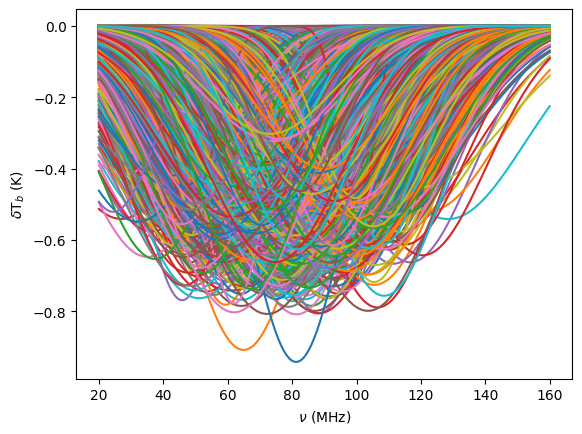

In [ ]:
for i in range(N):
  plt.plot(f,X_gauss[i,:])

plt.xlabel(r'$\nu$ (MHz)')
plt.ylabel(r'$\delta$T$_b$ (K)')
plt.savefig('gaussian_signal.png')

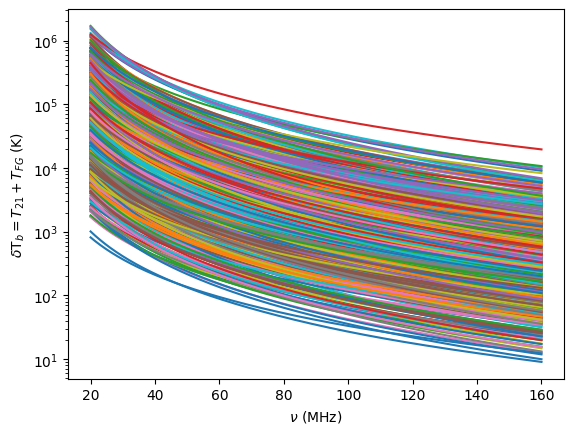

In [ ]:
for i in range(N):
  plt.plot(f,X_data[i,:])
plt.xlabel(r'$\nu$ (MHz)')
plt.ylabel(r'$\delta$T$_b$$=T_{21}+T_{FG}$ (K)')
plt.yscale('log')
plt.savefig('comb_signal.png')

Text(0, 0.5, '$\\delta$T$_b$$=T_{21}+T_{FG}$ (K)')

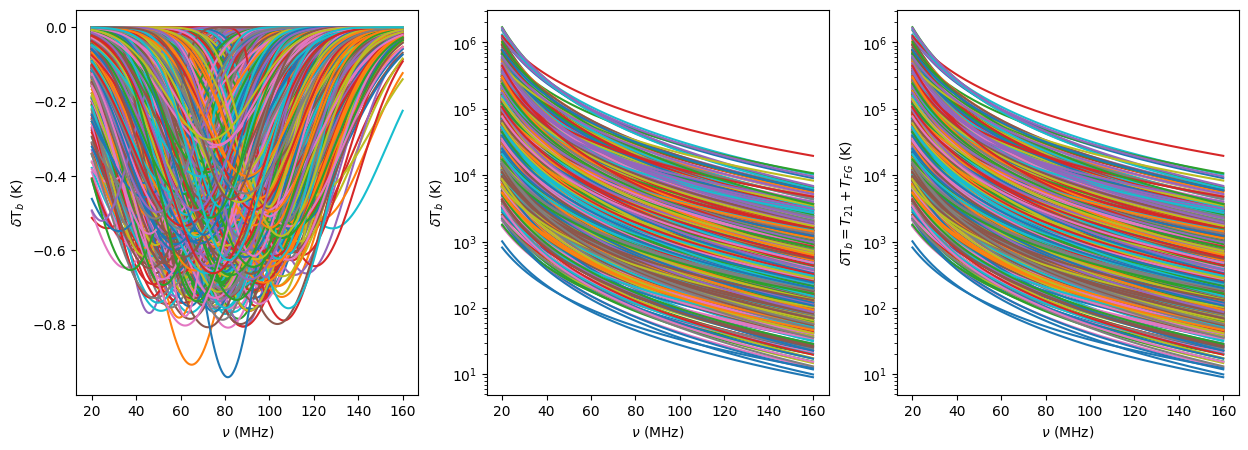

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
for i in range(N):
  ax[0].plot(f,X_gauss[i,:])
  ax[1].plot(f,X_fg[i,:])

for i in range(N):
  ax[2].plot(f,X_data[i,:])
ax[1].set_yscale('log')
ax[2].set_yscale('log')
# ax[0].set_title('Gaussian Function/Signal')
# ax[1].set_title('Foreground')
# ax[2].set_title('Observed/Combined data')
ax[0].set_xlabel(r'$\nu$ (MHz)')
ax[1].set_xlabel(r'$\nu$ (MHz)')
ax[2].set_xlabel(r'$\nu$ (MHz)')
ax[0].set_ylabel(r'$\delta$T$_b$ (K)')
ax[1].set_ylabel(r'$\delta$T$_b$ (K)')
ax[2].set_ylabel(r'$\delta$T$_b$$=T_{21}+T_{FG}$ (K)')

## **Scaling**

In [ ]:
scaler_x =  StandardScaler()
# scaler_x =  MinMaxScaler(feature_range=(0,2*np.pi))
scaler_x.fit(X_data)
X = scaler_x.transform(X_data)

scaler_y = StandardScaler()
scaler_y.fit(Y_data)
Y = scaler_y.transform(Y_data)

## **Data Split**

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.1,random_state = 2)

In [ ]:
x_train, y_train = shuffle(x_train, y_train, random_state=2)

# **Parameter Estimation - No foreground**

## **HQ**

### **Encoding**

In [ ]:
qubits= int(np.log2(X.shape[1]))
dev = qml.device("default.qubit",wires=qubits)

@qml.qnode(dev)
def encode(inputs):
  qml.AmplitudeEmbedding(inputs,wires=range(qubits),normalize=True)
  return qml.state()

In [ ]:
state = encode(X)

In [ ]:
x_state = state.numpy()
x_state = x_state.astype('float32')

In [ ]:
x_state.shape

(2000, 512)

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x_state,Y,test_size = 0.1,random_state = 2)

In [ ]:
x_train, y_train = shuffle(x_train, y_train, random_state=2)

### **Network**

In [ ]:
n_qubits = 7
layers = 4
dev1 = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev1,interface='tf')
def qnode1(inputs, weights):
    # for i in range(n_qubits):
    #   qml.Hadamard(wires = i)
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights,imprimitive=qml.ops.CZ, wires=range(n_qubits))
    # qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    # qml.RandomLayers(weights,wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [ ]:
dev2 = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev2,interface='tf')
def qnode2(inputs, weights):
    # for i in range(n_qubits):
    #   qml.Hadamard(wires = i)
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    # qml.StronglyEntanglingLayers(weights,imprimitive=qml.ops.CZ, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    # qml.RandomLayers(weights,wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [ ]:
# ip = np.random.rand(n_qubits), np.random.rand(1,n_qubits,3)
# fig, ax = qml.draw_mpl(qnode1,style='pennylane',expansion_strategy='device')(*ip)
# plt.show()

In [ ]:
weight_shapes_1 = {"weights": (layers, n_qubits,3)}
weight_specs = {"weights": {"initializer": "random_uniform"}}
weight_shapes_2 = {"weights": (layers, n_qubits)}

qlayer_1 = qml.qnn.KerasLayer(qnode1, weight_shapes_1, output_dim=n_qubits)
qlayer_2 = qml.qnn.KerasLayer(qnode2, weight_shapes_2, output_dim=n_qubits)
clayer1 = Dense(32, activation='tanh',input_shape=(Nf,),trainable=False)
clayer2 = Dense(n_qubits,activation='tanh')
clayer3 = Dense(5,activation='relu')
clayer4 = Dense(18,activation='tanh')
clayer5 = Dense(Y_data.shape[1],activation='linear')
hq_model = keras.Sequential([clayer1,clayer2, qlayer_1,clayer5])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-3,
    patience=10,
    mode="auto",
    restore_best_weights=True,
    start_from_epoch=0,
)

In [ ]:

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-1, decay_steps=1000, decay_rate=0.9)
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
# opt = tf.keras.optimizers.SGD(learning_rate=0.5)
hq_model.compile(opt, loss='mean_squared_error')

In [ ]:
history = hq_model.fit(x_train, y_train, epochs=100, batch_size=512,validation_split=0.1,callbacks=[callback],verbose=1,shuffle=True)

Epoch 1/100
4/4 [==============================] - 9s 2s/step - loss: 1.2059 - val_loss: 0.9382
Epoch 2/100
4/4 [==============================] - 8s 2s/step - loss: 0.9468 - val_loss: 0.7253
Epoch 3/100
4/4 [==============================] - 7s 2s/step - loss: 0.7203 - val_loss: 0.6608
Epoch 4/100
4/4 [==============================] - 8s 2s/step - loss: 0.6452 - val_loss: 0.5412
Epoch 5/100
4/4 [==============================] - 7s 2s/step - loss: 0.5444 - val_loss: 0.4846
Epoch 6/100
4/4 [==============================] - 8s 2s/step - loss: 0.4993 - val_loss: 0.4374
Epoch 7/100
4/4 [==============================] - 7s 2s/step - loss: 0.4579 - val_loss: 0.3910
Epoch 8/100
4/4 [==============================] - 8s 2s/step - loss: 0.4234 - val_loss: 0.3714
Epoch 9/100
4/4 [==============================] - 7s 2s/step - loss: 0.4072 - val_loss: 0.3477
Epoch 10/100
4/4 [==============================] - 7s 2s/step - loss: 0.3925 - val_loss: 0.3207
Epoch 11/100
4/4 [=====================

In [ ]:
hq_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                16416     
                                                                 
 dense_1 (Dense)             (None, 7)                 231       
                                                                 
 keras_layer (KerasLayer)    (None, 7)                 84        
                                                                 
 dense_4 (Dense)             (None, 3)                 24        
                                                                 
Total params: 16755 (65.45 KB)
Trainable params: 339 (1.32 KB)
Non-trainable params: 16416 (64.12 KB)
_________________________________________________________________


In [ ]:
loss= history.history['loss']
val_loss = history.history['val_loss']
# accuracy = history.history['accuracy']
# val_accuracy = history.history['val_accuracy']

Text(0, 0.5, 'Validation Loss')

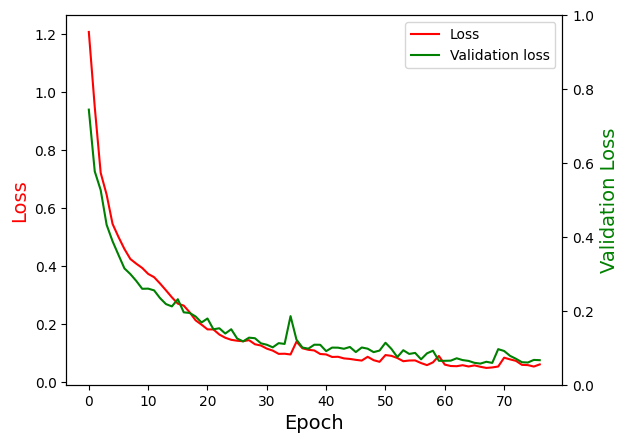

In [ ]:
fig,ax = plt.subplots()
ax.plot(loss, color="red", label= 'Loss')
ax.plot( val_loss, color="green", label= 'Validation loss')
ax.legend()
ax.set_xlabel("Epoch",fontsize=14)
ax.set_ylabel("Loss",color="red",fontsize=14)
ax2=ax.twinx()
ax2.set_ylabel("Validation Loss",color="green",fontsize=14)


In [ ]:
test_loss = hq_model.evaluate(x_test,y_test)

7/7 [==============================] - 2s 273ms/step - loss: 0.0458


In [ ]:
# Compute the output

Y_pre = hq_model.predict(x_test)

Y_pred = scaler_y.inverse_transform(Y_pre)
Y_test = scaler_y.inverse_transform(y_test)


# R2 Score
r2score= r2_score(y_test, Y_pre, multioutput='uniform_average')
Amplitude_r2score= r2_score(y_test[:,0], Y_pre[:,0])
print("Amplitude_R2score=", Amplitude_r2score)

Mean_r2score= r2_score(y_test[:,1], Y_pre[:,1])
print("Mean_R2score=", Mean_r2score)

Std_Deviation_r2score= r2_score(y_test[:,2], Y_pre[:,2])
print("Std_Deviation_R2score=", Std_Deviation_r2score)


from math import sqrt
#RMSE Score
mse = mean_squared_error(y_test, Y_pre, multioutput='raw_values')
A_rmse= sqrt(mse[0])
m_rmse= sqrt(mse[1])
std_rmse= sqrt(mse[2])

print("Amplitude_RMSE=",A_rmse)
print("Mean_RMSE=",m_rmse)
print("Std_Deviation_RMSE=",std_rmse)

7/7 [==============================] - 2s 296ms/step
Amplitude_R2score= 0.9392253879840733
Mean_R2score= 0.9730041060134289
Std_Deviation_R2score= 0.9212096748852396
Amplitude_RMSE= 0.22488395533385488
Mean_RMSE= 0.15082385657813402
Std_Deviation_RMSE= 0.2529770404549389


In [ ]:
r2_score(y_test,Y_pre)

0.944479722960914

In [ ]:
h,y,z, =Y_pred[0]
h1,y1,z1 = Y_test[0]

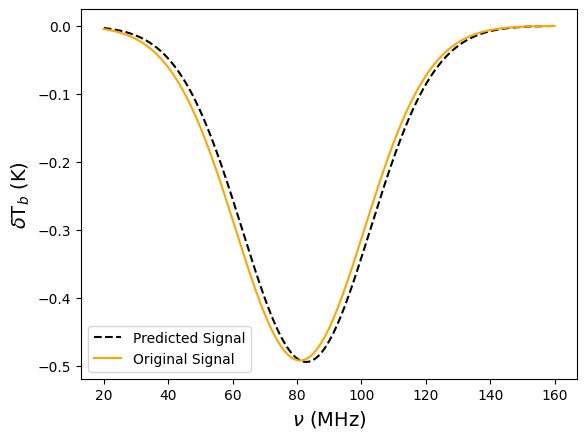

In [ ]:
plt.plot(f,gauss(h,y,z,f),color='black',linestyle='--',label = 'Predicted Signal')
plt.plot(f,gauss(h1,y1,z1,f),color='orange',label = 'Original Signal')
plt.xlabel(r'$\nu$ (MHz)',fontsize = 14)
plt.ylabel(r'$\delta$T$_b$ (K)',fontsize = 14)
# plt.xticks(np.arange(20,160,70))
# plt.yticks(np.arange(0,-1.0,100))
plt.legend()
plt.savefig("OnlySignal.png")

[46 51 39 63  6 69 49 78 95 15]


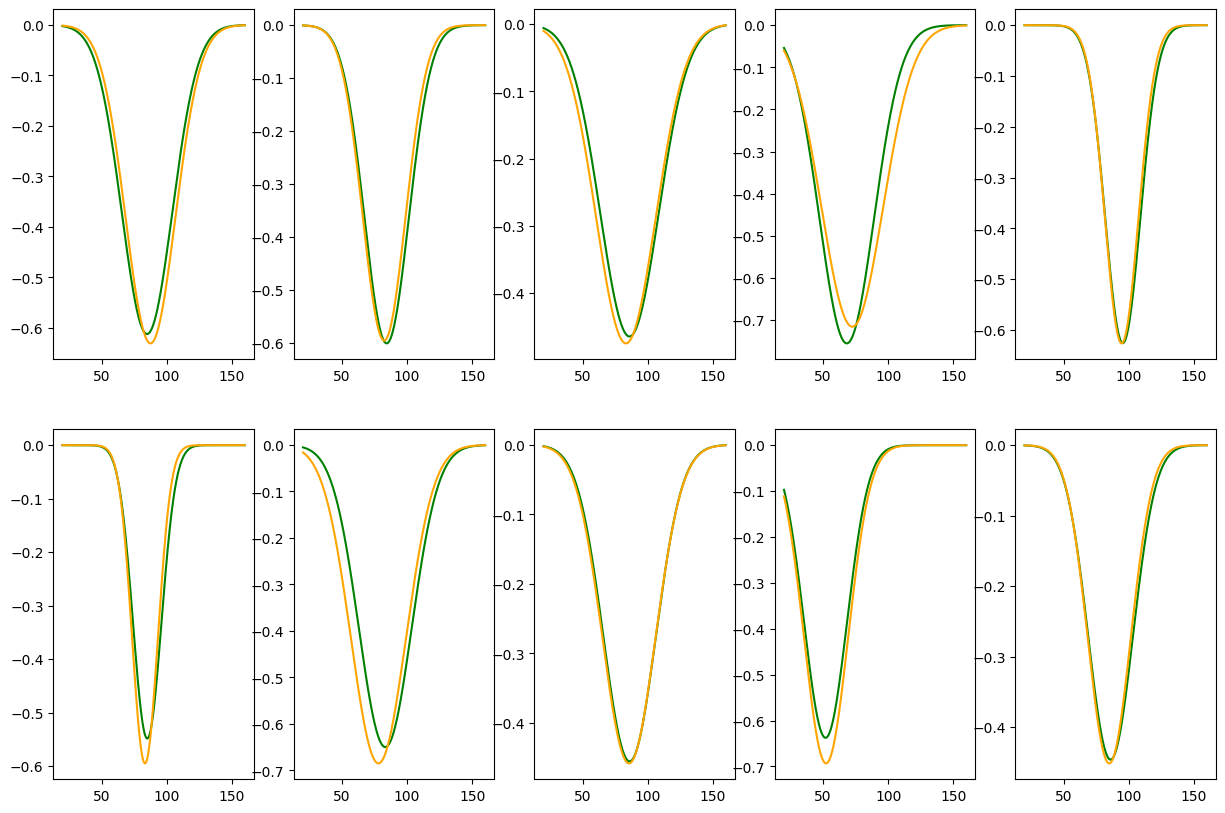

In [ ]:
# np.random.seed(5)
fig,ax = plt.subplots(2,5,figsize=(15,10))
indx = np.random.randint(low=0,high=99,size=10)
print(indx)
for i in range(2):
  if i==0:
    ind = indx[:5]
  else:
    ind = indx[5:]
  for j in range(len(ind)):
    h,y,z =Y_pred[ind[j]]
    h1,y1,z1 = Y_test[ind[j]]
    ax[i][j].plot(f,gauss(h,y,z,f),color='green')
    ax[i][j].plot(f,gauss(h1,y1,z1,f),color='orange')

In [ ]:
Amp, meanh, stdh = Y_pred.T
Ampt, meant, stdt = Y_test.T

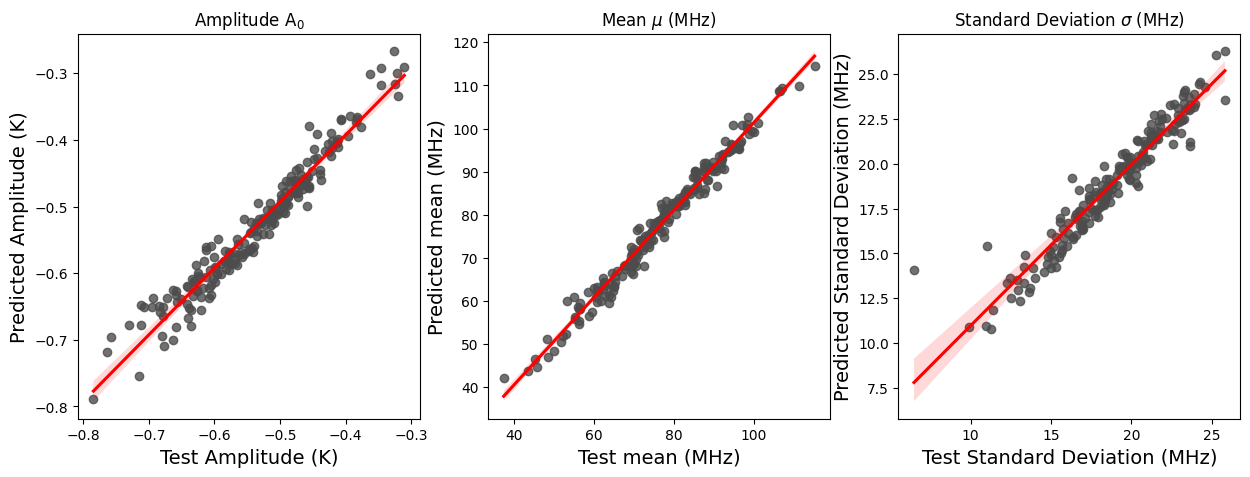

In [ ]:
fig,axe = plt.subplots(1,3,figsize= (15,5))
sns.regplot(x=Ampt,y=Amp,ax=axe[0],ci=99, marker="o", color=".3", line_kws=dict(color="r"))
sns.regplot(x=meant,y=meanh,ax=axe[1],ci=99, marker="o", color=".3", line_kws=dict(color="r"))
sns.regplot(x=stdt,y=stdh,ax=axe[2],ci=99, marker="o", color=".3", line_kws=dict(color="r"))
axe[0].set_xlabel('Test Amplitude (K)',fontsize = 14)
axe[0].set_ylabel('Predicted Amplitude (K)',fontsize = 14)
axe[1].set_xlabel('Test mean (MHz)',fontsize = 14)
axe[1].set_ylabel('Predicted mean (MHz)',fontsize = 14)
axe[2].set_xlabel('Test Standard Deviation (MHz)',fontsize = 14)
axe[2].set_ylabel('Predicted Standard Deviation (MHz)',fontsize = 14)
axe[0].set_title('Amplitude A$_{0}$')
axe[1].set_title('Mean ' r'$ \mu$ (MHz)')
axe[2].set_title('Standard Deviation ' r'$ \sigma$ (MHz)')
plt.savefig('predsonly.png')

## **Classical**

In [ ]:
def custom_loss(y_true, y_pred):
    # Define a weight to emphasize the Gaussian parameters (you can adjust this)
    weight_gaussian = 20.0

    # Split the true and predicted parameters into Gaussian and linear parts
    true_gaussian, true_linear = tf.split(y_true, [3, 2], axis=-1)
    pred_gaussian, pred_linear = tf.split(y_pred, [3, 2], axis=-1)

    # Compute mean squared error for Gaussian and linear parts separately
    mse_gaussian = tf.reduce_mean(tf.square(true_gaussian - pred_gaussian))
    mse_linear = tf.reduce_mean(tf.square(true_linear - pred_linear))

    # Combine the losses with the weight
    total_loss = mse_gaussian/weight_gaussian +  mse_linear

    return total_loss

In [ ]:
c_model = keras.Sequential([
    Dense(1024, activation='tanh', input_shape=(x_train.shape[1],)),
    Dense(27, activation='relu'),
    Dense(18, activation='relu'),
    Dense(y_train.shape[1],activation='linear')  # Output layer with the same number of parameters
])

# Learning Rate Scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3, decay_steps=1000, decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
c_model.compile(optimizer=optimizer, loss='mean_squared_error')

In [ ]:
# Train the model
epochs = 500  # Adjust as needed
batch_size = 256  # Adjust as needed
history = c_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1,callbacks=[callback],shuffle=True)

Epoch 1/500
7/7 [==============================] - 1s 46ms/step - loss: 1.0614 - val_loss: 0.5155
Epoch 2/500
7/7 [==============================] - 0s 28ms/step - loss: 0.4906 - val_loss: 0.3803
Epoch 3/500
7/7 [==============================] - 0s 25ms/step - loss: 0.3855 - val_loss: 0.3037
Epoch 4/500
7/7 [==============================] - 0s 27ms/step - loss: 0.3181 - val_loss: 0.2542
Epoch 5/500
7/7 [==============================] - 0s 29ms/step - loss: 0.2727 - val_loss: 0.2360
Epoch 6/500
7/7 [==============================] - 0s 32ms/step - loss: 0.2449 - val_loss: 0.1999
Epoch 7/500
7/7 [==============================] - 0s 31ms/step - loss: 0.2203 - val_loss: 0.1842
Epoch 8/500
7/7 [==============================] - 0s 29ms/step - loss: 0.1978 - val_loss: 0.1635
Epoch 9/500
7/7 [==============================] - 0s 27ms/step - loss: 0.1780 - val_loss: 0.1591
Epoch 10/500
7/7 [==============================] - 0s 30ms/step - loss: 0.1637 - val_loss: 0.1384
Epoch 11/500
7/7 [=

In [ ]:
c_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 1024)              525312    
                                                                 
 dense_26 (Dense)            (None, 27)                27675     
                                                                 
 dense_27 (Dense)            (None, 18)                504       
                                                                 
 dense_28 (Dense)            (None, 3)                 57        
                                                                 
Total params: 553548 (2.11 MB)
Trainable params: 553548 (2.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
loss= history.history['loss']
val_loss = history.history['val_loss']
# accuracy = history.history['accuracy']
# val_accuracy = history.history['val_accuracy']

Text(0, 0.5, 'Validation Loss')

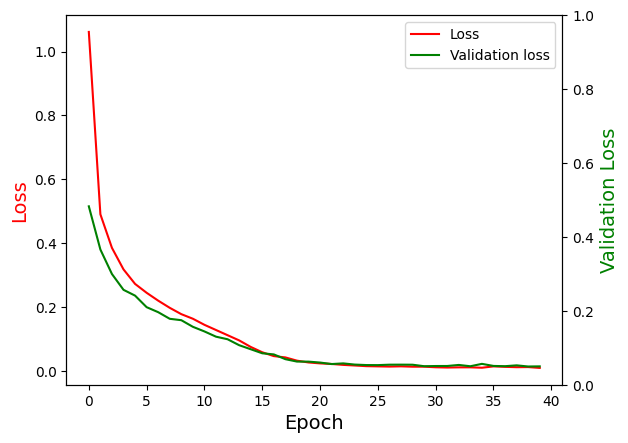

In [ ]:
fig,ax = plt.subplots()
ax.plot(loss, color="red", label= 'Loss')
ax.plot( val_loss, color="green", label= 'Validation loss')
ax.legend()
ax.set_xlabel("Epoch",fontsize=14)
ax.set_ylabel("Loss",color="red",fontsize=14)
ax2=ax.twinx()
ax2.set_ylabel("Validation Loss",color="green",fontsize=14)


In [ ]:
test_loss = c_model.evaluate(x_test,y_test)

7/7 [==============================] - 0s 4ms/step - loss: 0.0142


In [ ]:
# Compute the output

Y_pre = c_model.predict(x_test)

Y_pred = scaler_y.inverse_transform(Y_pre)
Y_test = scaler_y.inverse_transform(y_test)


# R2 Score
r2score= r2_score(y_test, Y_pre, multioutput='uniform_average')
Amplitude_r2score= r2_score(y_test[:,0], Y_pre[:,0])
print("Amplitude_R2score=", Amplitude_r2score)

Mean_r2score= r2_score(y_test[:,1], Y_pre[:,1])
print("Mean_R2score=", Mean_r2score)

Std_Deviation_r2score= r2_score(y_test[:,2], Y_pre[:,2])
print("Std_Deviation_R2score=", Std_Deviation_r2score)


from math import sqrt
#RMSE Score
mse = mean_squared_error(y_test, Y_pre, multioutput='raw_values')
A_rmse= sqrt(mse[0])
m_rmse= sqrt(mse[1])
std_rmse= sqrt(mse[2])
print("Amplitude_RMSE=",A_rmse)
print("Mean_RMSE=",m_rmse)
print("Std_Deviation_RMSE=",std_rmse)

7/7 [==============================] - 0s 5ms/step
Amplitude_R2score= 0.9771151128402576
Mean_R2score= 0.9948107977533085
Std_Deviation_R2score= 0.9764457358894841
Amplitude_RMSE= 0.13799767243978975
Mean_RMSE= 0.06612588283442603
Std_Deviation_RMSE= 0.13831823275408128


In [ ]:
r2_score(y_test,Y_pre)

0.9827905488276834

In [ ]:
h,y,z =Y_pred[0]
h1,y1,z1 = Y_test[0]

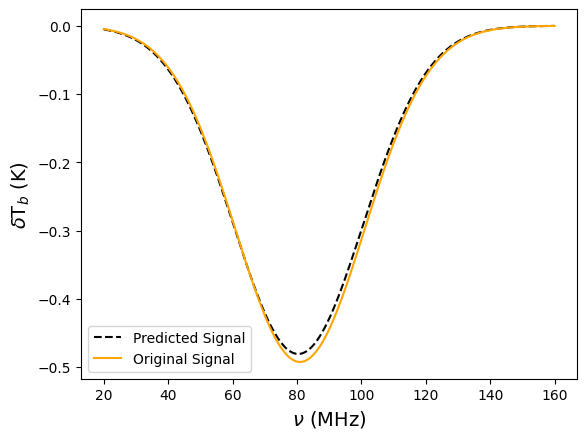

In [ ]:
plt.plot(f,gauss(h,y,z,f),color='black',linestyle='--',label = 'Predicted Signal')
plt.plot(f,gauss(h1,y1,z1,f),color='orange',label = 'Original Signal')
plt.xlabel(r'$\nu$ (MHz)',fontsize = 14)
plt.ylabel(r'$\delta$T$_b$ (K)',fontsize = 14)
# plt.xticks(np.arange(20,160,70))
# plt.yticks(np.arange(0,-1.0,100))
plt.legend()

[40 62 97 10 54 26 54 50 40 62]


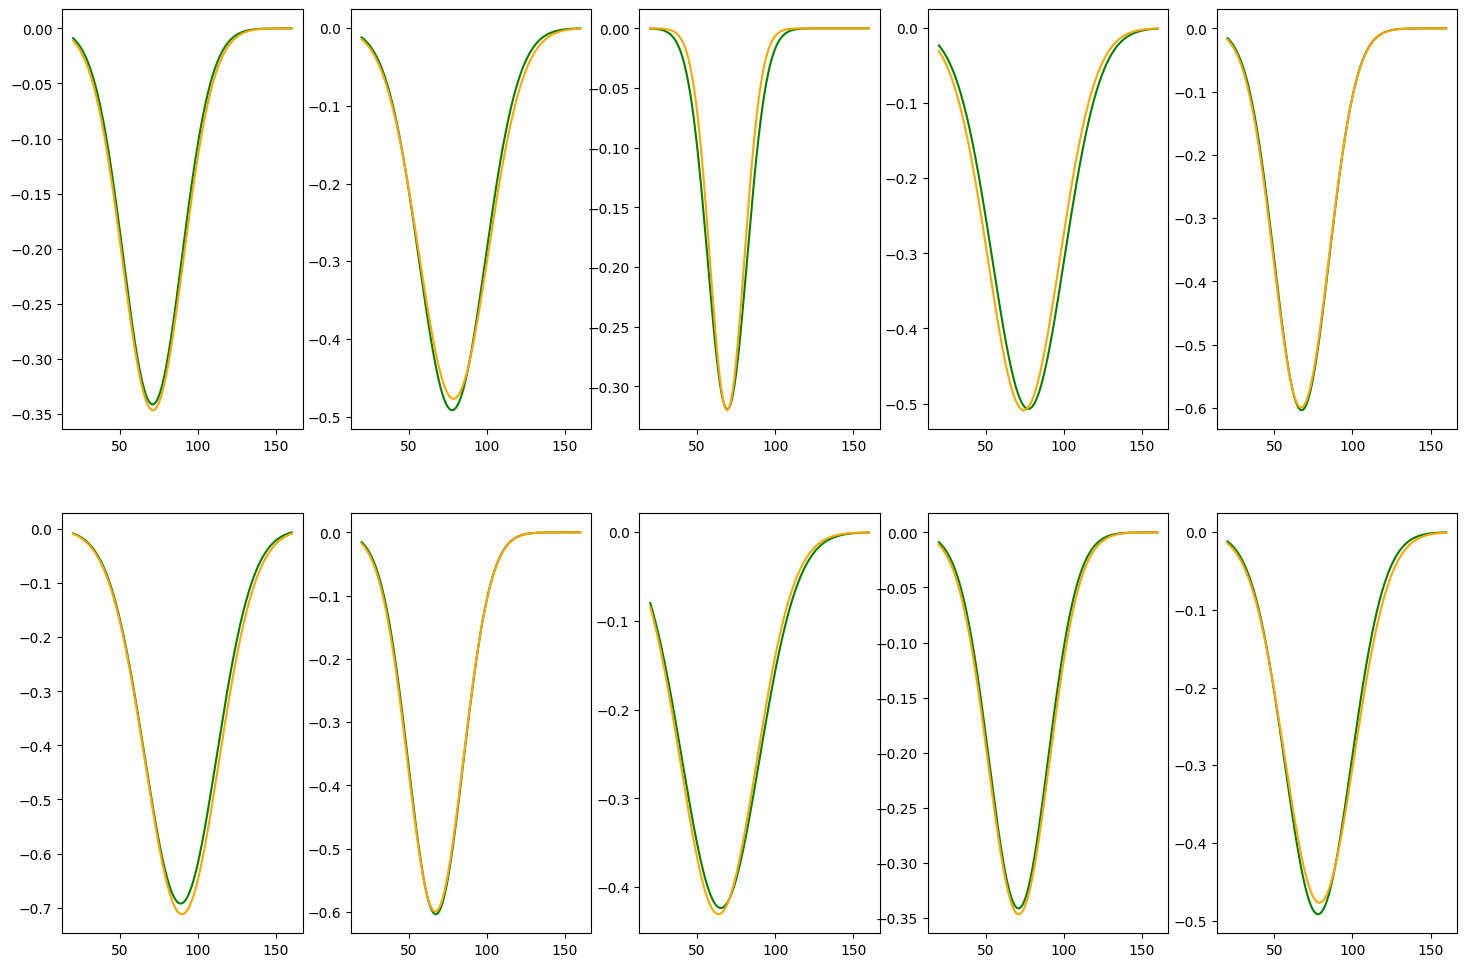

In [ ]:
# np.random.seed(5)
fig,ax = plt.subplots(2,5,figsize=(18,12))
indx = np.random.randint(low=0,high=99,size=10)
print(indx)
for i in range(2):
  if i==0:
    ind = indx[:5]
  else:
    ind = indx[5:]
  for j in range(len(ind)):
    h,y,z, =Y_pred[ind[j]]
    h1,y1,z1 = Y_test[ind[j]]
    ax[i][j].plot(f,gauss(h,y,z,f),color='green')
    ax[i][j].plot(f,gauss(h1,y1,z1,f),color='orange')

In [ ]:
Amp, meanh, stdh = Y_pred.T
Ampt, meant, stdt = Y_test.T

Text(0.5, 1.0, 'Standard Deviation $ \\sigma$ (MHz)')

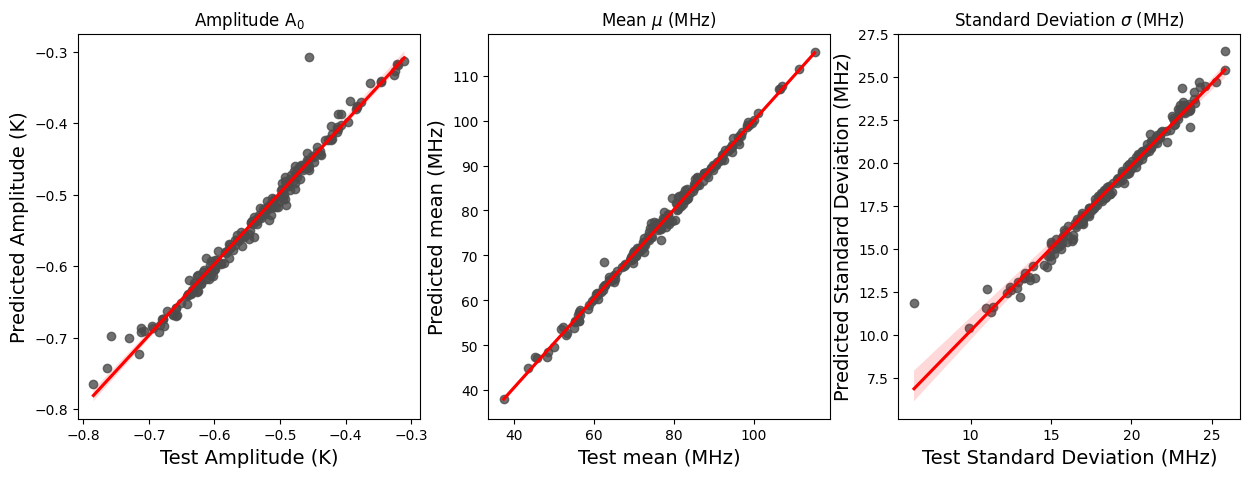

In [ ]:
fig,axe = plt.subplots(1,3,figsize= (15,5))
sns.regplot(x=Ampt,y=Amp,ax=axe[0],ci=99, marker="o", color=".3", line_kws=dict(color="r"))
sns.regplot(x=meant,y=meanh,ax=axe[1],ci=99, marker="o", color=".3", line_kws=dict(color="r"))
sns.regplot(x=stdt,y=stdh,ax=axe[2],ci=99, marker="o", color=".3", line_kws=dict(color="r"))
axe[0].set_xlabel('Test Amplitude (K)',fontsize = 14)
axe[0].set_ylabel('Predicted Amplitude (K)',fontsize = 14)
axe[1].set_xlabel('Test mean (MHz)',fontsize = 14)
axe[1].set_ylabel('Predicted mean (MHz)',fontsize = 14)
axe[2].set_xlabel('Test Standard Deviation (MHz)',fontsize = 14)
axe[2].set_ylabel('Predicted Standard Deviation (MHz)',fontsize = 14)
axe[0].set_title('Amplitude A$_{0}$')
axe[1].set_title('Mean ' r'$ \mu$ (MHz)')
axe[2].set_title('Standard Deviation ' r'$ \sigma$ (MHz)')

## **AE-ANN**

In [ ]:
x_ae = X.reshape(len(X),512,1,1)

In [ ]:
def AE(x):
  input = Input(shape=(512,1,1))
  conv_1 = Conv2D(64,kernel_size=(2,1))(input)
  pool_1 = AvgPool2D((2,1))(conv_1)
  conv_2 = Conv2D(32,kernel_size=(2,1))(pool_1)
  pool_2 = AvgPool2D((2,1))(conv_2)
  conv_3 = Conv2D(16,kernel_size=(2,1))(pool_2)
  pool_3 = AvgPool2D((2,1))(conv_3)
  conv_4 = Conv2D(8,kernel_size=(2,1))(pool_3)
  pool_4 = AvgPool2D((2,1))(conv_4)
  flat = Flatten()(pool_4)
  dense_1 = Dense(128)(flat)
  bn = BatchNormalization()(dense_1)
  dense_2 = Dense(64)(bn)
  return keras.models.Model(inputs=input, outputs = dense_2)

In [ ]:
ae=AE(x_ae)
# optimizer = tf.keras.optimizers.adam(learning_rate=0.001)
optimizer = tf.keras.optimizers.experimental.SGD(learning_rate=0.001)
ae.compile(optimizer=optimizer, loss='mean_squared_error')

In [ ]:
ae_hist = ae.fit(x=x_ae,y=x_ae,epochs=100, batch_size=100, validation_split=0.1,shuffle=True)

Epoch 1/100
18/18 [==============================] - 5s 86ms/step - loss: 2.2314 - val_loss: 1.1880
Epoch 2/100
18/18 [==============================] - 1s 78ms/step - loss: 2.0408 - val_loss: 1.1852
Epoch 3/100
18/18 [==============================] - 1s 81ms/step - loss: 1.8931 - val_loss: 1.1800
Epoch 4/100
18/18 [==============================] - 1s 83ms/step - loss: 1.7808 - val_loss: 1.1750
Epoch 5/100
18/18 [==============================] - 1s 82ms/step - loss: 1.6937 - val_loss: 1.1714
Epoch 6/100
18/18 [==============================] - 1s 80ms/step - loss: 1.6227 - val_loss: 1.1683
Epoch 7/100
18/18 [==============================] - 1s 78ms/step - loss: 1.5670 - val_loss: 1.1657
Epoch 8/100
18/18 [==============================] - 1s 78ms/step - loss: 1.5150 - val_loss: 1.1630
Epoch 9/100
18/18 [==============================] - 1s 78ms/step - loss: 1.4732 - val_loss: 1.1602
Epoch 10/100
18/18 [==============================] - 1s 78ms/step - loss: 1.4357 - val_loss: 1.1571

In [ ]:
ae.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 1, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 511, 1, 64)        192       
                                                                 
 average_pooling2d_4 (Avera  (None, 255, 1, 64)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_5 (Conv2D)           (None, 254, 1, 32)        4128      
                                                                 
 average_pooling2d_5 (Avera  (None, 127, 1, 32)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_6 (Conv2D)           (None, 126, 1, 16)        1040

In [ ]:
loss= ae_hist.history['loss']
val_loss = ae_hist.history['val_loss']

Text(0, 0.5, 'Validation Loss')

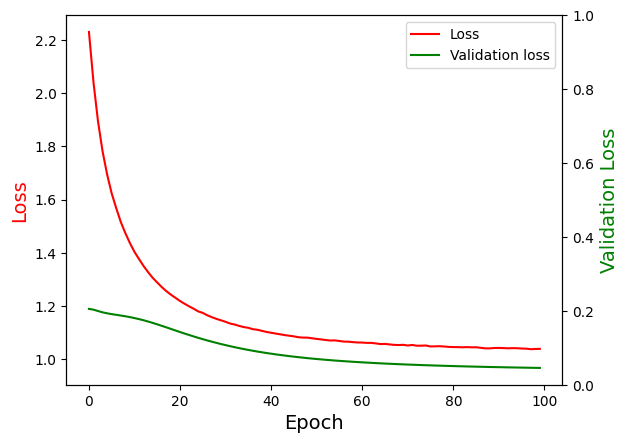

In [ ]:
fig,ax = plt.subplots()
ax.plot(loss, color="red", label= 'Loss')
ax.plot( val_loss, color="green", label= 'Validation loss')
ax.legend()
ax.set_xlabel("Epoch",fontsize=14)
ax.set_ylabel("Loss",color="red",fontsize=14)
ax2=ax.twinx()
ax2.set_ylabel("Validation Loss",color="green",fontsize=14)

### **Data Split**

In [ ]:
x_red = ae(x_ae).numpy()

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x_red,Y,test_size = 0.1,random_state = 2)

In [ ]:
x_train, y_train = shuffle(x_train, y_train, random_state=2)

### **ANN**

In [ ]:
def model():
  dense_1 = Dense(27,activation='relu',input_shape=(x_red.shape[1],))
  dense_2 = Dense(18,activation='relu')
  dense_3 = Dense(y_train.shape[1],activation='linear')
  model = keras.Sequential([dense_1,dense_2,dense_3])
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=optimizer, loss='mean_squared_error')
  return model

In [ ]:
c_mod = model()

In [ ]:
c_hist = c_mod.fit(x_train,y_train,epochs = 100, batch_size=128,validation_split=0.1,shuffle=True)

Epoch 1/100
13/13 [==============================] - 3s 44ms/step - loss: 0.9984 - val_loss: 0.9400
Epoch 2/100
13/13 [==============================] - 0s 9ms/step - loss: 0.9179 - val_loss: 0.8583
Epoch 3/100
13/13 [==============================] - 0s 9ms/step - loss: 0.8468 - val_loss: 0.7768
Epoch 4/100
13/13 [==============================] - 0s 9ms/step - loss: 0.7748 - val_loss: 0.6966
Epoch 5/100
13/13 [==============================] - 0s 11ms/step - loss: 0.6989 - val_loss: 0.6127
Epoch 6/100
13/13 [==============================] - 0s 10ms/step - loss: 0.6201 - val_loss: 0.5269
Epoch 7/100
13/13 [==============================] - 0s 9ms/step - loss: 0.5426 - val_loss: 0.4443
Epoch 8/100
13/13 [==============================] - 0s 10ms/step - loss: 0.4673 - val_loss: 0.3692
Epoch 9/100
13/13 [==============================] - 0s 11ms/step - loss: 0.3976 - val_loss: 0.2988
Epoch 10/100
13/13 [==============================] - 0s 13ms/step - loss: 0.3351 - val_loss: 0.2417
Epo

In [ ]:
c_mod.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 27)                1755      
                                                                 
 dense_5 (Dense)             (None, 18)                504       
                                                                 
 dense_6 (Dense)             (None, 3)                 57        
                                                                 
Total params: 2316 (9.05 KB)
Trainable params: 2316 (9.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
loss= c_hist.history['loss']
val_loss = c_hist.history['val_loss']
# accuracy = history.history['accuracy']
# val_accuracy = history.history['val_accuracy']

Text(0, 0.5, 'Validation Loss')

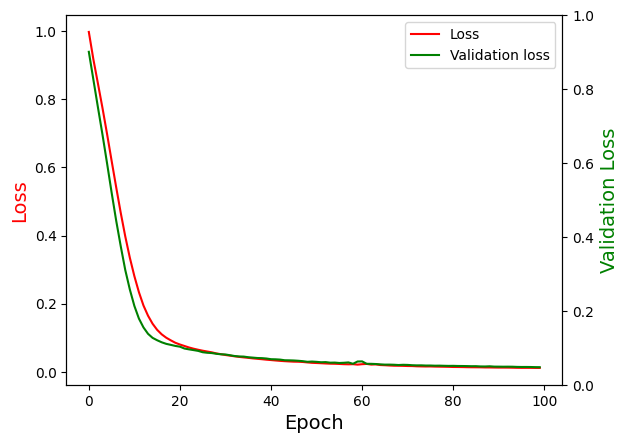

In [ ]:
fig,ax = plt.subplots()
ax.plot(loss, color="red", label= 'Loss')
ax.plot( val_loss, color="green", label= 'Validation loss')
ax.legend()
ax.set_xlabel("Epoch",fontsize=14)
ax.set_ylabel("Loss",color="red",fontsize=14)
ax2=ax.twinx()
ax2.set_ylabel("Validation Loss",color="green",fontsize=14)


In [ ]:
test_loss = c_mod.evaluate(x_test,y_test)

7/7 [==============================] - 0s 4ms/step - loss: 0.0106


In [ ]:
# Compute the output

Y_pre = c_mod.predict(x_test)

Y_pred = scaler_y.inverse_transform(Y_pre)
Y_test = scaler_y.inverse_transform(y_test)


# R2 Score
r2score= r2_score(y_test, Y_pre, multioutput='uniform_average')
Amplitude_r2score= r2_score(y_test[:,0], Y_pre[:,0])
print("Amplitude_R2score=", Amplitude_r2score)

Mean_r2score= r2_score(y_test[:,1], Y_pre[:,1])
print("Mean_R2score=", Mean_r2score)

Std_Deviation_r2score= r2_score(y_test[:,2], Y_pre[:,2])
print("Std_Deviation_R2score=", Std_Deviation_r2score)


from math import sqrt
#RMSE Score
mse = mean_squared_error(y_test, Y_pre, multioutput='raw_values')
A_rmse= sqrt(mse[0])
m_rmse= sqrt(mse[1])
std_rmse= sqrt(mse[2])
print("Amplitude_RMSE=",A_rmse)
print("Mean_RMSE=",m_rmse)
print("Std_Deviation_RMSE=",std_rmse)

7/7 [==============================] - 0s 3ms/step
Amplitude_R2score= 0.9881709955208531
Mean_R2score= 0.9881900999094714
Std_Deviation_R2score= 0.985289711858407
Amplitude_RMSE= 0.09921366016399576
Mean_RMSE= 0.09975721045960116
Std_Deviation_RMSE= 0.10930883132922008


In [ ]:
r2_score(y_test,Y_pre)

0.9872169357629105

[39 37 46 51 39 63  6 69 49 78]


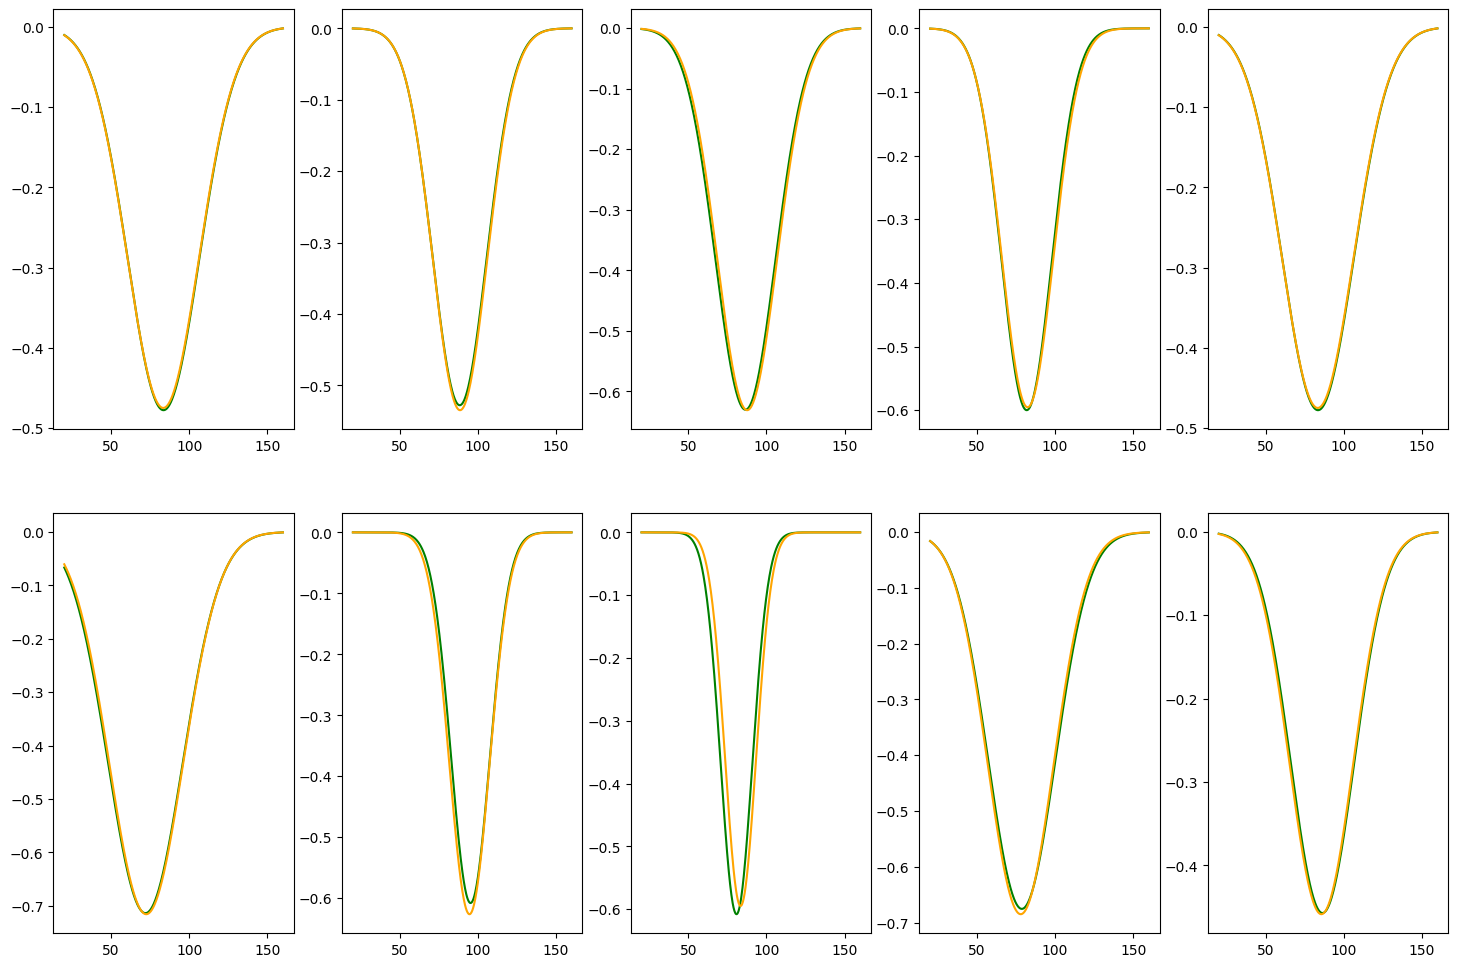

In [ ]:
# np.random.seed(5)
fig,ax = plt.subplots(2,5,figsize=(18,12))
indx = np.random.randint(low=0,high=99,size=10)
print(indx)
for i in range(2):
  if i==0:
    ind = indx[:5]
  else:
    ind = indx[5:]
  for j in range(len(ind)):
    h,y,z, =Y_pred[ind[j]]
    h1,y1,z1 = Y_test[ind[j]]
    ax[i][j].plot(f,gauss(h,y,z,f),color='green')
    ax[i][j].plot(f,gauss(h1,y1,z1,f),color='orange')

In [ ]:
Amp, meanh, stdh = Y_pred.T
Ampt, meant, stdt = Y_test.T

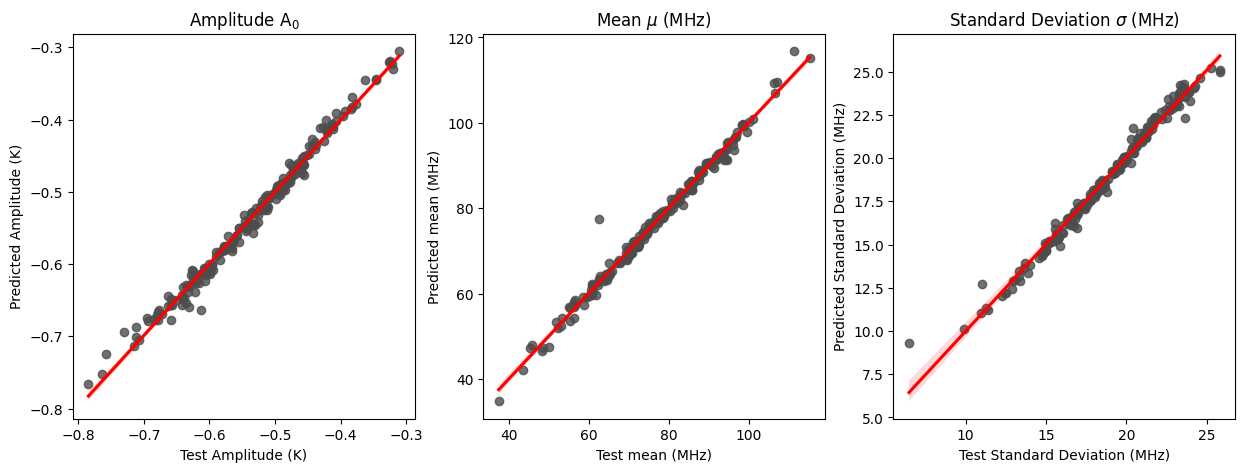

In [ ]:
fig,axe = plt.subplots(1,3,figsize= (15,5))
sns.regplot(x=Ampt,y=Amp,ax=axe[0],ci=99, marker="o", color=".3", line_kws=dict(color="r"))
sns.regplot(x=meant,y=meanh,ax=axe[1],ci=99, marker="o", color=".3", line_kws=dict(color="r"))
sns.regplot(x=stdt,y=stdh,ax=axe[2],ci=99, marker="o", color=".3", line_kws=dict(color="r"))
axe[0].set_xlabel('Test Amplitude (K)')
axe[0].set_ylabel('Predicted Amplitude (K)')
axe[1].set_xlabel('Test mean (MHz)')
axe[1].set_ylabel('Predicted mean (MHz)')
axe[2].set_xlabel('Test Standard Deviation (MHz)')
axe[2].set_ylabel('Predicted Standard Deviation (MHz)')
axe[0].set_title('Amplitude A$_{0}$')
axe[1].set_title('Mean ' r'$ \mu$ (MHz)')
axe[2].set_title('Standard Deviation ' r'$ \sigma$ (MHz)')
plt.savefig('predsonly.png')

### **Encoding+CNN+QNN+FNN**

# **Parameter Estimation**

## **Hybrid-Quantum**

In [ ]:
n_qubits = 10
layers = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev,interface='tf')
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights,imprimitive=qml.ops.CZ, wires=range(n_qubits))
    # qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    # qml.RandomLayers(weights,wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [ ]:
# n_qubits = 7
# layers = 4
# dev = qml.device("default.qubit", wires=n_qubits)

# @qml.qnode(dev,interface='tf')
# def qnode(inputs, weights):
#     AmplitudeEmbedding(inputs, wires=range(n_qubits),normalize=True)
#     qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
#     # qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
#     # qml.RandomLayers(weights,wires=range(n_qubits))
#     return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [ ]:
weight_shapes = {"weights": (layers, n_qubits,3)}
weight_specs = {"weights": {"initializer": "random_uniform"}}

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, weight_specs = weight_specs, output_dim=n_qubits)
clayer1 = Dense(32, activation='tanh',input_shape=(x_train.shape[1],),trainable=False)
clayer2 = Dense(n_qubits,activation='tanh',trainable=False)
clayer3 = Dense(5,activation='relu')
clayer4 = Dense(n_qubits,activation='relu')
clayer5 = Dense(y_train.shape[1],activation='linear')
hq_model = keras.Sequential([clayer1,clayer4,qlayer,clayer5])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-3,
    patience=10,
    mode="auto",
    restore_best_weights=True,
    start_from_epoch=0,
)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3, decay_steps=1000, decay_rate=0.9)
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
# opt = tf.keras.optimizers.SGD(learning_rate=0.5)
hq_model.compile(opt, loss='mean_squared_error')

In [ ]:
history = hq_model.fit(x_train, y_train, epochs=100, batch_size=512,callbacks=[callback],validation_split=0.1,verbose=1,shuffle=True)

Epoch 1/100
4/4 [==============================] - 75s 18s/step - loss: 1.7408 - val_loss: 1.1999
Epoch 2/100
4/4 [==============================] - 76s 18s/step - loss: 1.1327 - val_loss: 1.0147
Epoch 3/100
4/4 [==============================] - 73s 17s/step - loss: 0.9536 - val_loss: 0.9232
Epoch 4/100
4/4 [==============================] - 72s 17s/step - loss: 0.8758 - val_loss: 0.9298
Epoch 5/100
4/4 [==============================] - 73s 18s/step - loss: 0.8614 - val_loss: 0.9069
Epoch 6/100
4/4 [==============================] - 71s 16s/step - loss: 0.8429 - val_loss: 0.8693
Epoch 7/100
4/4 [==============================] - 70s 17s/step - loss: 0.8136 - val_loss: 0.8417
Epoch 8/100
4/4 [==============================] - 71s 17s/step - loss: 0.7914 - val_loss: 0.8200
Epoch 9/100
4/4 [==============================] - 70s 16s/step - loss: 0.7797 - val_loss: 0.8083
Epoch 10/100
4/4 [==============================] - 68s 16s/step - loss: 0.7735 - val_loss: 0.8043
Epoch 11/100
4/4 [=

In [ ]:
hq_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 32)                32800     
                                                                 
 dense_42 (Dense)            (None, 10)                330       
                                                                 
 keras_layer (KerasLayer)    (None, 10)                120       
                                                                 
 dense_43 (Dense)            (None, 7)                 77        
                                                                 
Total params: 33327 (130.18 KB)
Trainable params: 527 (2.06 KB)
Non-trainable params: 32800 (128.12 KB)
_________________________________________________________________


In [ ]:
loss= history.history['loss']
val_loss = history.history['val_loss']
# accuracy = history.history['accuracy']
# val_accuracy = history.history['val_accuracy']

Text(0, 0.5, 'Validation Loss')

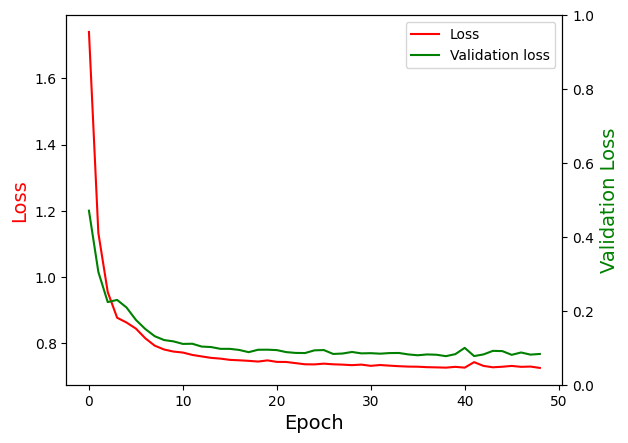

In [ ]:
fig,ax = plt.subplots()
ax.plot(loss, color="red", label= 'Loss')
ax.plot( val_loss, color="green", label= 'Validation loss')
ax.legend()
ax.set_xlabel("Epoch",fontsize=14)
ax.set_ylabel("Loss",color="red",fontsize=14)
ax2=ax.twinx()
ax2.set_ylabel("Validation Loss",color="green",fontsize=14)


In [ ]:
test_loss = hq_model.evaluate(x_test,y_test)

7/7 [==============================] - 6s 804ms/step - loss: 0.6706


In [ ]:
# Compute the output

Y_pre = hq_model.predict(x_test)

Y_pred = scaler_y.inverse_transform(Y_pre)
Y_test = scaler_y.inverse_transform(y_test)


# R2 Score
r2score= r2_score(y_test, Y_pre, multioutput='uniform_average')
Amplitude_r2score= r2_score(y_test[:,0], Y_pre[:,0])
print("Amplitude_R2score=", Amplitude_r2score)

Mean_r2score= r2_score(y_test[:,1], Y_pre[:,1])
print("Mean_R2score=", Mean_r2score)

Std_Deviation_r2score= r2_score(y_test[:,2], Y_pre[:,2])
print("Std_Deviation_R2score=", Std_Deviation_r2score)

a0_r2score= r2_score(y_test[:,3], Y_pre[:,3])
print("a0_R2score=",a0_r2score )

a1_r2score= r2_score(y_test[:,4], Y_pre[:,4])
print("a1_R2score=",a1_r2score)

a2_r2score= r2_score(y_test[:,5], Y_pre[:,5])
print("a2_R2score=",a2_r2score )

a3_r2score= r2_score(y_test[:,6], Y_pre[:,6])
print("a3_R2score=",a3_r2score)

from math import sqrt
#RMSE Score
mse = mean_squared_error(y_test, Y_pre, multioutput='raw_values')
A_rmse= sqrt(mse[0])
m_rmse= sqrt(mse[1])
std_rmse= sqrt(mse[2])
a0_rmse= sqrt(mse[3])
a1_rmse= sqrt(mse[4])
a2_rmse= sqrt(mse[5])
a3_rmse= sqrt(mse[6])
print("Amplitude_RMSE=",A_rmse)
print("Mean_RMSE=",m_rmse)
print("Std_Deviation_RMSE=",std_rmse)
print("a0_RMSE=",a0_rmse)
print("a1_RMSE=",a1_rmse)
print("a2_RMSE=",a2_rmse)
print("a3_RMSE=",a3_rmse)

7/7 [==============================] - 5s 765ms/step
Amplitude_R2score= -0.023394533463025446
Mean_R2score= -0.0035928944458725187
Std_Deviation_R2score= -0.01930962969073957
a0_R2score= 0.9795449793056493
a1_R2score= 0.9234403707448904
a2_R2score= -0.002924138599400994
a3_R2score= -0.006193580810016641
Amplitude_RMSE= 0.922824083615308
Mean_RMSE= 0.919602140425958
Std_Deviation_RMSE= 0.9099085057876126
a0_RMSE= 0.13496121560086735
a1_RMSE= 0.26854062274637
a2_RMSE= 1.038429326971837
a3_RMSE= 1.0002297878101691


In [ ]:
r2_score(y_test,Y_pre)

0.26393865329164085

In [ ]:
h,y,z,w,u,v,i =Y_pred[0]
h1,y1,z1,w1,u1,v1,i1 = Y_test[0]

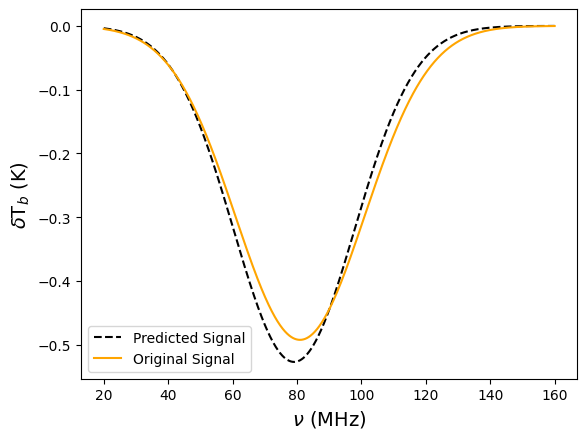

In [ ]:
plt.plot(f,gauss(h,y,z,f),color='black',linestyle='--',label = 'Predicted Signal')
plt.plot(f,gauss(h1,y1,z1,f),color='orange',label = 'Original Signal')
plt.xlabel(r'$\nu$ (MHz)',fontsize=14)
plt.ylabel(r'$\delta$T$_b$ (K)',fontsize=14)
plt.legend()
plt.savefig("OnlySignal.png")

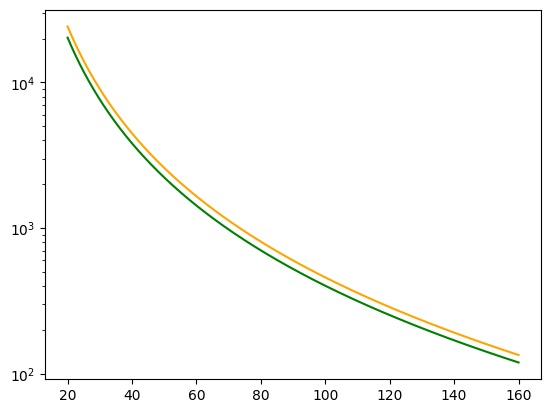

In [ ]:
plt.plot(f,logpoly([w,u,v,i],f,f0),color='green')
plt.plot(f,logpoly([w1,u1,v1,i1],f,f0),color='orange')
plt.yscale('log')

In [ ]:
# np.random.seed(5)
fig,ax = plt.subplots(4,5,figsize=(18,12))
indx = np.random.randint(low=0,high=99,size=10)
print(indx)
for i in range(2):
  if i==0:
    ind = indx[:5]
  else:
    ind = indx[5:]
  for j in range(len(ind)):
    h,y,z,w,u,v,k =Y_pred[ind[j]]
    h1,y1,z1,w1,u1,v1,k1 = Y_test[ind[j]]
    ax[i][j].plot(f,gauss(h,y,z,f),color='green')
    ax[i][j].plot(f,gauss(h1,y1,z1,f),color='orange')
    ax[i+2][j].plot(f,logpoly([w,u,v,k],f,f0),color='green')
    ax[i+2][j].plot(f,logpoly([w1,u1,v1,k1],f,f0),color='orange')
    ax[i+2][j].set_yscale('log')

In [ ]:
h,y,z,w,u,v,i =Y_pred[1]
h1,y1,z1,w1,u1,v1,i1 = Y_test[1]

In [ ]:
plt.plot(f,gauss(h,y,z,f),color='black',linestyle='--',label = 'Predicted Signal')
plt.plot(f,gauss(h1,y1,z1,f),color='orange',label = 'Original Signal')
plt.xlabel(r'$\nu$ (MHz)')
plt.ylabel(r'$\delta$T$_b$ (K)')
plt.legend()
plt.savefig("Signal-fore.png")

In [ ]:
plt.plot(f,logpoly([w,u,v,i],f,f0),color='black',linestyle='--',label = 'Predicted Signal')
plt.plot(f,logpoly([w1,u1,v1,i1],f,f0),color='orange',label = 'Original Signal')
plt.xlabel(r'$\nu$ (MHz)')
plt.ylabel(r'$\delta$T$_b$ (K)')
plt.yscale('log')
plt.legend()
plt.savefig("fore.png")

In [ ]:
amp, meanh, stdh, a0h,a1h,a2h,a3h = Y_pred.T
ampt, meant, stdt, a0t,a1t,a2t,a3t = Y_test.T

In [ ]:
fig,axe = plt.subplots(2,2,figsize= (16,10))
sns.regplot(x=a0t,y=a0h,ax=axe[0][0],ci=99, marker="o", color=".3", line_kws=dict(color="r"))
sns.regplot(x=a1t,y=a1h,ax=axe[0][1],ci=99, marker="o", color=".3", line_kws=dict(color="r"))
sns.regplot(x=a2t,y=a2h,ax=axe[1][0],ci=99, marker="o", color=".3", line_kws=dict(color="r"))
sns.regplot(x=a3t,y=a3h,ax=axe[1][1],ci=99, marker="o", color=".3", line_kws=dict(color="r"))
axe[0][0].set_xlabel('Test values',fontsize=14)
axe[0][0].set_ylabel('Predicted values',fontsize=14)
axe[0][1].set_xlabel('Test values',fontsize=14)
axe[0][1].set_ylabel('Predicted values',fontsize=14)
axe[1][0].set_xlabel('Test values',fontsize=14)
axe[1][0].set_ylabel('Predicted values',fontsize=14)
axe[1][1].set_xlabel('Test values',fontsize=14)
axe[1][1].set_ylabel('Predicted values',fontsize=14)
axe[0][0].set_title('a$_{0}$')
axe[0][1].set_title('a$_{1}$')
axe[1][0].set_title('a$_{2}$')
axe[1][1].set_title('a$_{3}$')
plt.savefig('predsonly-fore.png')

In [ ]:
fig,axe = plt.subplots(1,3,figsize= (15,5))
sns.regplot(x=ampt,y=amp,ax=axe[0],ci=99, marker="o", color=".3", line_kws=dict(color="r"))
sns.regplot(x=meant,y=meanh,ax=axe[1],ci=99, marker="o", color=".3", line_kws=dict(color="r"))
sns.regplot(x=stdt,y=stdh,ax=axe[2],ci=99, marker="o", color=".3", line_kws=dict(color="r"))
axe[0].set_xlabel('Test Amplitude (K)',fontsize=14)
axe[0].set_ylabel('Predicted Amplitude (K)',fontsize=14)
axe[1].set_xlabel('Test mean (MHz)',fontsize=14)
axe[1].set_ylabel('Predicted mean (MHz)',fontsize=14)
axe[2].set_xlabel('Test Standard Deviation (MHz)',fontsize=14)
axe[2].set_ylabel('Predicted Standard Deviation (MHz)',fontsize=14)
axe[0].set_title('Amplitude A$_{0}$')
axe[1].set_title('Mean ' r'$ \mu$ (MHz)')
axe[2].set_title('Standard Deviation ' r'$ \sigma$ (MHz)')
plt.savefig('predsonly-sig.png')

## **Classical**

In [ ]:
c_model = keras.Sequential([
    Dense(128, activation='tanh', input_shape=(x_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    keras.layers.Dense(y_train.shape[1],activation='linear')  # Output layer with the same number of parameters
])

# Learning Rate Scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3, decay_steps=1000, decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
c_model.compile(optimizer=optimizer, loss='mean_squared_error')

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-3,
    patience=10,
    mode="auto",
    restore_best_weights=True,
    start_from_epoch=0,
)

In [ ]:
# Train the model
epochs = 500  # Adjust as needed
batch_size = 128  # Adjust as needed
history = c_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1,callbacks=[callback],shuffle=True)

Epoch 1/500
13/13 [==============================] - 2s 33ms/step - loss: 0.9799 - val_loss: 0.9275
Epoch 2/500
13/13 [==============================] - 0s 16ms/step - loss: 0.8813 - val_loss: 0.8823
Epoch 3/500
13/13 [==============================] - 0s 15ms/step - loss: 0.8547 - val_loss: 0.8656
Epoch 4/500
13/13 [==============================] - 0s 13ms/step - loss: 0.8350 - val_loss: 0.8389
Epoch 5/500
13/13 [==============================] - 0s 13ms/step - loss: 0.8130 - val_loss: 0.8271
Epoch 6/500
13/13 [==============================] - 0s 13ms/step - loss: 0.7974 - val_loss: 0.8183
Epoch 7/500
13/13 [==============================] - 0s 14ms/step - loss: 0.7865 - val_loss: 0.8021
Epoch 8/500
13/13 [==============================] - 0s 11ms/step - loss: 0.7712 - val_loss: 0.8101
Epoch 9/500
13/13 [==============================] - 0s 10ms/step - loss: 0.7669 - val_loss: 0.8001
Epoch 10/500
13/13 [==============================] - 0s 10ms/step - loss: 0.7578 - val_loss: 0.7961

In [ ]:
c_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 128)               131200    
                                                                 
 dense_35 (Dense)            (None, 64)                8256      
                                                                 
 dense_36 (Dense)            (None, 32)                2080      
                                                                 
 dense_37 (Dense)            (None, 16)                528       
                                                                 
 dense_38 (Dense)            (None, 7)                 119       
                                                                 
Total params: 142183 (555.40 KB)
Trainable params: 142183 (555.40 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
loss= history.history['loss']
val_loss = history.history['val_loss']
# accuracy = history.history['accuracy']
# val_accuracy = history.history['val_accuracy']

Text(0, 0.5, 'Validation Loss')

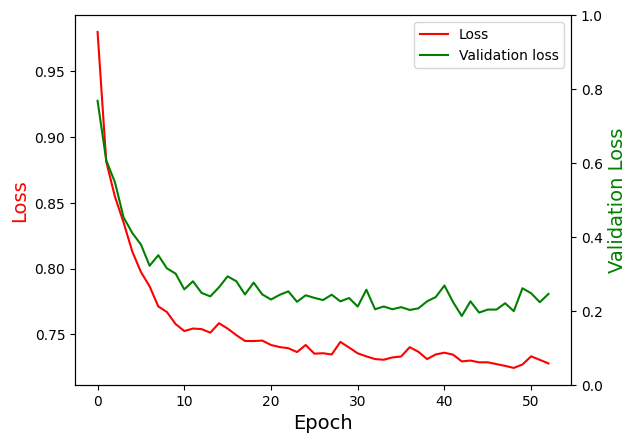

In [ ]:
fig,ax = plt.subplots()
ax.plot(loss, color="red", label= 'Loss')
ax.plot( val_loss, color="green", label= 'Validation loss')
ax.legend()
ax.set_xlabel("Epoch",fontsize=14)
ax.set_ylabel("Loss",color="red",fontsize=14)
ax2=ax.twinx()
ax2.set_ylabel("Validation Loss",color="green",fontsize=14)


In [ ]:
test_loss = c_model.evaluate(x_test,y_test)

7/7 [==============================] - 0s 3ms/step - loss: 0.6766


In [ ]:
# Compute the output

Y_pre = c_model.predict(x_test)

Y_pred = scaler_y.inverse_transform(Y_pre)
Y_test = scaler_y.inverse_transform(y_test)


# R2 Score
r2score= r2_score(y_test, Y_pre, multioutput='uniform_average')
Amplitude_r2score= r2_score(y_test[:,0], Y_pre[:,0])
print("Amplitude_R2score=", Amplitude_r2score)

Mean_r2score= r2_score(y_test[:,1], Y_pre[:,1])
print("Mean_R2score=", Mean_r2score)

Std_Deviation_r2score= r2_score(y_test[:,2], Y_pre[:,2])
print("Std_Deviation_R2score=", Std_Deviation_r2score)

a0_r2score= r2_score(y_test[:,3], Y_pre[:,3])
print("a0_R2score=",a0_r2score )

a1_r2score= r2_score(y_test[:,4], Y_pre[:,4])
print("a1_R2score=",a1_r2score)

a2_r2score= r2_score(y_test[:,5], Y_pre[:,5])
print("a2_R2score=",a2_r2score )

a3_r2score= r2_score(y_test[:,5], Y_pre[:,5])
print("a3_R2score=",a3_r2score)

from math import sqrt
#RMSE Score
mse = mean_squared_error(y_test, Y_pre, multioutput='raw_values')
A_rmse= sqrt(mse[0])
m_rmse= sqrt(mse[1])
std_rmse= sqrt(mse[2])
a0_rmse= sqrt(mse[3])
a1_rmse= sqrt(mse[4])
a2_rmse= sqrt(mse[5])
a3_rmse= sqrt(mse[6])
print("Amplitude_RMSE=",A_rmse)
print("Mean_RMSE=",m_rmse)
print("Std_Deviation_RMSE=",std_rmse)
print("a0_RMSE=",a0_rmse)
print("a1_RMSE=",a1_rmse)
print("a2_RMSE=",a2_rmse)
print("a3_RMSE=",a3_rmse)

7/7 [==============================] - 0s 2ms/step
Amplitude_R2score= -0.029235863992611133
Mean_R2score= -0.051496891038247394
Std_Deviation_R2score= -0.013722905368521054
a0_R2score= 0.960710651423533
a1_R2score= 0.9344113486758325
a2_R2score= 0.0016343052391658563
a3_R2score= 0.0016343052391658563
Amplitude_RMSE= 0.9254539835166032
Mean_RMSE= 0.9412937628892647
Std_Deviation_RMSE= 0.9074115252890537
a0_RMSE= 0.18704514232919967
a1_RMSE= 0.24855610303406683
a2_RMSE= 1.0360667291429402
a3_RMSE= 0.9999566194699464


In [ ]:
r2_score(y_test,Y_pre)

0.25666522617875737

In [ ]:
h,y,z,w,u,v,i =Y_pred[0]
h1,y1,z1,w1,u1,v1,i1 = Y_test[0]

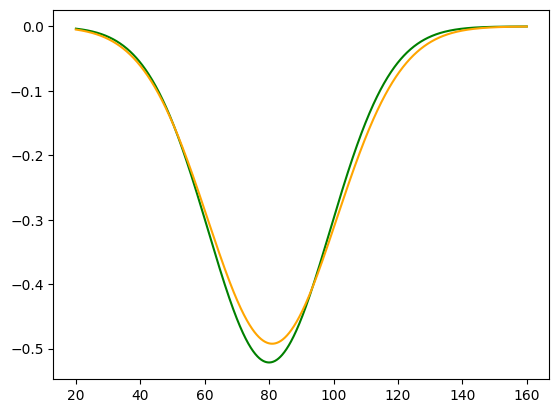

In [ ]:
plt.plot(f,gauss(h,y,z,f),color='green')
plt.plot(f,gauss(h1,y1,z1,f),color='orange')

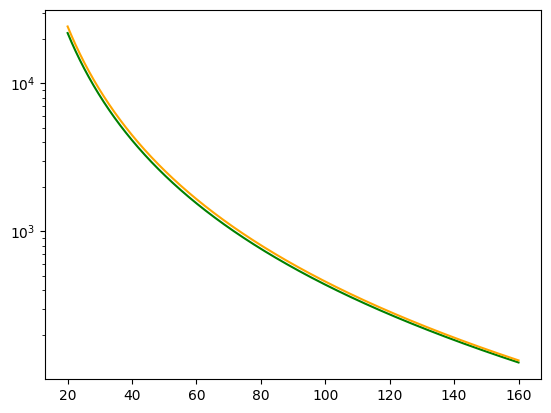

In [ ]:
plt.plot(f,logpoly([w,u,v,i],f,f0),color='green')
plt.plot(f,logpoly([w1,u1,v1,i1],f,f0),color='orange')
plt.yscale('log')

[50 40 62 74 98 64 54 29  5  6]


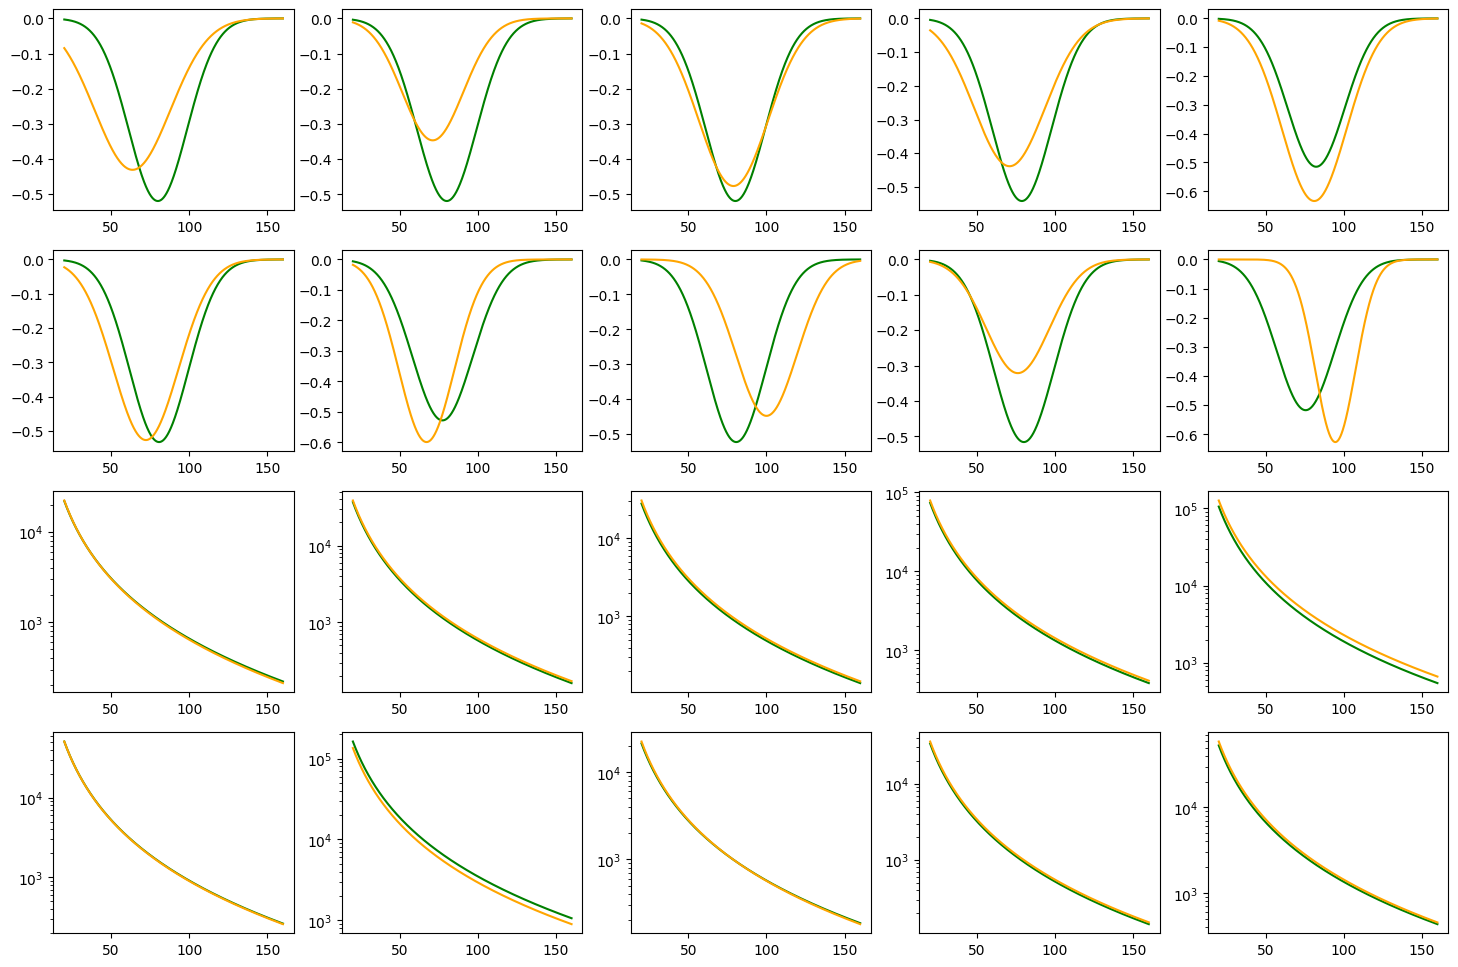

In [ ]:
# np.random.seed(5)
fig,ax = plt.subplots(4,5,figsize=(18,12))
indx = np.random.randint(low=0,high=99,size=10)
print(indx)
for i in range(2):
  if i==0:
    ind = indx[:5]
  else:
    ind = indx[5:]
  for j in range(len(ind)):
    h,y,z,w,u,v,k =Y_pred[ind[j]]
    h1,y1,z1,w1,u1,v1,k1 = Y_test[ind[j]]
    ax[i][j].plot(f,gauss(h,y,z,f),color='green')
    ax[i][j].plot(f,gauss(h1,y1,z1,f),color='orange')
    ax[i+2][j].plot(f,logpoly([w,u,v,k],f,f0),color='green')
    ax[i+2][j].plot(f,logpoly([w1,u1,v1,k1],f,f0),color='orange')
    ax[i+2][j].set_yscale('log')